In [30]:
# Import necessary modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold

from gensim.models.word2vec import Word2Vec

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
#import language_check
from textblob import TextBlob
import spacy

from sklearn.model_selection import train_test_split, KFold

from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

from scipy.sparse import csr_matrix

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasRegressor

nlp = spacy.load('en')

stopwords = stopwords.words('english')

%matplotlib inline

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Numpy version: 1.16.4
Pandas version: 0.25.1
Seaborn version: 0.8.1


In [29]:
!pip install skll

     |████████████████████████████████| 92kB 9.7MB/s  eta 0:00:01
     |████████████████████████████████| 133kB 5.9MB/s eta 0:00:01
     |████████████████████████████████| 51kB 10.5MB/s eta 0:00:01
     |████████████████████████████████| 153kB 15.6MB/s eta 0:00:01
  Created wheel for skll: filename=skll-2.0-py2.py3-none-any.whl size=106200 sha256=1629b17c0350a320d734ae44178f568e765ce99da5b23242910177d5e7e433e9
  Stored in directory: /Users/xuechunwang/Library/Caches/pip/wheels/b4/52/a9/86c4029267f506d435c63f6278d65452564a07c97b59368d5f
  Created wheel for tabulate: filename=tabulate-0.8.6-cp36-none-any.whl size=30506 sha256=b2f56690ecb3d09d6b17dd619f64367a306537381999c6e78d98328adc724860
  Stored in directory: /Users/xuechunwang/Library/Caches/pip/wheels/9c/9b/f4/eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
Successfully built skll tabulate


## Process Overview (Recap)

### Apply grammar and spelling corrections

Feature importances generated from the extra trees algorithm did not rank grammar and spelling errors highly, suggesting that perhaps the essays could be processed "as is". On the other hand, word embeddings rely on known words and many usage examples. Misspelled words will either be ignored if their count is below the minimum, or worse, if misspelled to an existing word with a different meaning, the vectors could change the performance of the model in a way that might not be useful. LanguageTool will be used for applying these corrections.

### Clean essays

Remove less helpful parts of essay texts, i.e. punctuation, pronouns and capital letters and return lemma to be processed into word embeddings. SpaCy is a simple and efficient tool for this task.

### Generate word embeddings

SpaCy could also be used to generate word embeddings, however its simple 'en' language model is trained on a corpus that is very different from school essays. It also uses context sensitive tensors which don't provide specific word vectors. 

Instead, Gensim's Word2Vec will be used to generate a model based on the all available essays, not only from the "training_set" which includes target scores, but also from the "validation" and "test" sets which are otherwise not useful. Finally, cleaned essays of the "training_set" will be passed into the word model to generate averaged 300-dimensional word vectors.

### Prepare inputs

There are eight topics which each have a different scale for scoring. To deal with this there are several possible approaches. First, each topic could be processed individually and the resultant kappa scores would be averaged. This approach is useful if certain features are particularly useful for grading a specific topic. On the other hand, fewer essays mean fewer examples to learn from. 

An alternate approach is to combine all topics by scaling the scores with a min-max scaler to a common range, e.g. 0-60. This approach increases the number of examples nearly 8-fold. 

### Classification or regression?

Automatic scoring can now be thought of as either a classification or a regression problem. For classification the target variable needs to be one-hot encoded to the range of unique target scores and the output layer of the neural network also needs to have the same dimension. For regression, the target variable and output layer have a single dimension. Where the classification results are approximated or rounded through `softmax` activation and again when reversing the min-max scaling, the regression results are only rounded after scaling. This might be the reason regression performs slightly better on this data set.

In [5]:
def correct_language(df):
    """
    use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
    """
    #tool = language_check.LanguageTool('en-US')
    #TextBlob(data).correct()
    #df['matches'] = df['essay'].apply(lambda txt: tool.check(txt))
    #df['corrections'] = df.apply(lambda l: len(l['matches']), axis=1)
    df['corrected'] = df['essay'].apply(lambda txt: TextBlob(txt).correct())
    df['corrections'] = df.apply(lambda x: UncommonWords(x['essay'],x['corrected']),axis=1)
    return df

In [6]:
# Function to return all uncommon words 
def UncommonWords(A, B): 
  
    # count will contain all the word counts 
    count = 0
    #for i, j in zip(x, y):
    for word1,word2 in zip(A.split(), B.split()):
      if word1 != word2:
        count = count + 1
    return count

In [31]:
# read essays from training_set
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})

# apply spelling and grammar corrections
#training_set = correct_language(training_set)

training_set.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
len(training_set)

12976

In [16]:
import datetime
from timeit import default_timer as timer
from datetime import timedelta
start = timer()
text = training_set["essay"][1]
corret_text = TextBlob(training_set["essay"][1]).correct()
print(UncommonWords(text,corret_text))
end = timer()
print(timedelta(seconds=end-start))

20
0:00:04.759351


16


In [32]:
# read essays from validation and test sets

valid_set  = pd.read_csv('valid_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})
test_set  = pd.read_csv('test_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})

combo_set = pd.concat([valid_set, test_set], sort=False)

# apply spelling and grammar corrections
#combo_set = correct_language(combo_set)

In [33]:
combo_set = pd.concat([combo_set, training_set], sort=False)
combo_set.to_pickle('combo_set.pkl')

In [34]:
len(combo_set)

21448

In [10]:
# skip if using language tool above
# training_set = pd.read_pickle('training_features.pkl')
# combo_set = pd.read_pickle('combo_set.pkl')

### Generate word embeddings with Word2Vec

In [36]:
#stopwords = stopwords.words('english')
# Clean training_set essays before feeding them to the Word2Vec model.
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_essays(essays, logging=False):
    texts = []
    counter = 1
    for essay in essays.essay:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(essays)))
        counter += 1
        essay = nlp(essay, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in essay if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [37]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', training_set['essay'].shape)
train_cleaned = cleanup_essays(training_set, logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (12976,)
Processed 2000 out of 12976 documents.
Processed 4000 out of 12976 documents.
Processed 6000 out of 12976 documents.
Processed 8000 out of 12976 documents.
Processed 10000 out of 12976 documents.
Processed 12000 out of 12976 documents.
Cleaned up training data shape:  (12976,)


In [40]:
# Define function to preprocess text for a word2vec model
def cleanup_essay_word2vec(essays, logging=False):
    sentences = []
    counter = 1
    for essay in essays:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(essays)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        essay = nlp(essay, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        essay = " ".join([tok.lemma_.lower() for tok in essay])
        # Split into sentences based on punctuation
        essay = re.split("[\.?!;] ", essay)
        # Remove commas, periods, and other punctuation (mostly commas)
        essay = [re.sub("[\.,;:!?]", "", sent) for sent in essay]
        # Split into words
        essay = [sent.split() for sent in essay]
        sentences += essay
        counter += 1
    return sentences

In [42]:
cleaned_word2vec = cleanup_essay_word2vec(combo_set['essay'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(cleaned_word2vec))

Processed 2000 out of 21448 documents
Processed 4000 out of 21448 documents
Processed 6000 out of 21448 documents
Processed 8000 out of 21448 documents
Processed 10000 out of 21448 documents
Processed 12000 out of 21448 documents
Processed 14000 out of 21448 documents
Processed 16000 out of 21448 documents
Processed 18000 out of 21448 documents
Processed 20000 out of 21448 documents
Cleaned up training data size (i.e. number of sentences):  283418


In [43]:
text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))
wordvec_model.save('wordvec_model')
print("Word2Vec model saved.")

Training Word2Vec model...
Word2Vec model created.
13920 unique words represented by 300 dimensional vectors
Word2Vec model saved.


In [44]:
# Define function to create averaged word vectors given a cleaned text.
def create_average_vec(essay):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in essay.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [45]:
# Create word vectors
cleaned_vec = np.zeros((training_set.shape[0], text_dim), dtype="float32")  
for i in range(len(train_cleaned)):
    cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Word vectors for all essays in the training data set are of shape:", cleaned_vec.shape)

Word vectors for all essays in the training data set are of shape: (12976, 300)


In [58]:
#cleaned_vec
np.save("cleaned_vec",cleaned_vec)
#np.load("cleaned_vec.npy")

## Neural Network Models

In [61]:
# Read generated features from file:
additional_features = pd.read_pickle('training_features.pkl')

# Use select features from Gini feature importances
feature_list = [
                'word_count',
#                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

additional_features = additional_features[feature_list]

stdscaler = StandardScaler()
additional_features = stdscaler.fit_transform(additional_features)
additional_features.shape

(12976, 30)

In [62]:
pd.DataFrame(feature_list)

,0
0,word_count
1,similarity
2,token_count
3,unique_token_count
4,nostop_count
5,sent_count
6,ner_count
7,comma
8,question
9,exclamation


In [64]:
# Combine topic number, target score, additional features and cleaned word vectors
all_data = pd.concat([training_set[['topic','target_score']],pd.DataFrame(additional_features), pd.DataFrame(cleaned_vec)], axis=1)
all_data.shape

(12976, 332)

In [65]:
all_data

,topic,target_score,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,1,8,0.655391,0.969168,0.729153,0.858392,0.764633,0.383135,-0.708233,1.102640,...,-0.062647,-0.011562,0.095986,-0.031466,0.048008,0.021794,0.040137,-0.106035,-0.133596,-0.030171
1,1,9,1.115846,1.146246,1.035377,1.279858,1.052187,0.627089,1.006870,0.458983,...,-0.093963,0.027637,0.089060,-0.006007,0.083559,-0.013223,0.035278,-0.107073,-0.162545,-0.051506
2,1,7,0.319998,0.903077,0.282367,0.577414,0.266205,0.220498,0.320828,0.137154,...,-0.095261,-0.015849,0.122792,-0.007651,0.067961,-0.015729,-0.026543,-0.109897,-0.127190,0.012358
3,1,10,1.712732,1.108949,1.637784,2.066596,1.934022,1.602908,1.692911,0.566259,...,-0.077728,0.009018,0.072374,-0.001877,0.051347,-0.000652,0.012310,-0.117932,-0.160473,-0.038814
4,1,8,1.377339,1.130027,1.346621,1.322005,1.195965,1.277635,0.320828,0.566259,...,-0.064819,0.019868,0.089539,-0.057345,0.068295,-0.013280,0.042585,-0.138927,-0.137735,-0.025444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,8,35,3.537497,0.216347,3.520309,3.232653,3.189677,2.578727,7.009730,4.535478,...,-0.039371,-0.028118,0.103683,-0.069745,0.062956,-0.019978,0.033431,-0.138210,-0.137638,-0.060760
12972,8,32,1.837793,0.703426,1.933968,1.504640,1.809415,2.578727,4.608586,1.531745,...,-0.003191,-0.004110,0.116283,-0.051381,0.077047,-0.029928,0.057730,-0.160998,-0.122820,-0.031451
12973,8,40,3.378327,0.663670,3.540389,3.668169,3.736031,2.822682,3.236503,4.213650,...,-0.011969,0.002705,0.073556,-0.053269,0.057815,-0.009234,0.061383,-0.139154,-0.181638,-0.093599
12974,8,40,1.928747,0.958630,2.089590,1.954205,2.279087,2.009499,1.178380,3.462716,...,0.008413,0.024483,0.071253,-0.054869,0.085374,-0.026309,0.052860,-0.154178,-0.202759,-0.083210


## Approach 1: Pass each topic individually through neural network

In [66]:
# Build model
output_dim = 1
input_dim = all_data.shape[1]-2
dropout = 0.2

model = None
model = Sequential()

# Densely Connected Neural Network (Multi-Layer Perceptron)
model.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
model.add(Dropout(dropout))
# model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
# model.add(Dropout(dropout))
model.add(Dense(output_dim))
model.summary()

# Compile the model
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 14)                4634      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 15        
Total params: 4,649
Trainable params: 4,649
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Run each topic individually through neural network
kappa_list = []
weights = []
epochs = 100

for topic in range(1,9):
    # split data
    X = all_data[all_data.topic == topic].drop(['topic', 'target_score'], axis=1)
    y = all_data[all_data.topic == topic].target_score.to_frame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
    estimator = model.fit(X_train, y_train,
#                       validation_split=0.3,
                      epochs=epochs, batch_size=15, verbose=0)
    # get predictions
    y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))
    
    # get topic kappa score
    kappa_list.append(kappa(y_test.values, y_pred.round(0).astype(int).values, weights='quadratic'))

    # get weights (number of essays)
    weights.append(y_test.shape[0]/all_data.shape[0])    

# get weighted average kappa
qwk = mean_quadratic_weighted_kappa(kappa_list, weights=1) # weights)
print('Combined Kappa score: {:.2f}%'.format(qwk * 100))

Combined Kappa score: 71.16%


Again with cross-validation:

In [68]:
# Cross-validation

kappa_dict = {}

for topic in range(1,9):
    
    model = None
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=input_dim, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')

    X = all_data[all_data.topic == topic].drop(['topic', 'target_score'], axis=1)
    y = all_data[all_data.topic == topic].target_score.to_frame()
    # split data
    kf = KFold(n_splits=5, random_state=26)
    kappa_list = []
    for train, test in kf.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        model.fit(X_train, y_train, epochs=200, batch_size=15, verbose=0) 
        y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))
        kappa_list.append(kappa(y_pred.round(0).astype(int).values, 
                        y.iloc[test].values, 
                        weights='quadratic'))
    print("Kappa for topic", topic, ": {:.3f}%".format(np.mean(kappa_list)))
    kappa_dict[topic] = np.mean(kappa_list)

mqwk = mean_quadratic_weighted_kappa(list(kappa_dict.values()), weights=1) # weights)
print('Combined Kappa score: {:.4f}%'.format(mqwk))

Kappa for topic 1 : 0.846%
Kappa for topic 2 : 0.747%
Kappa for topic 3 : 0.704%
Kappa for topic 4 : 0.793%
Kappa for topic 5 : 0.811%
Kappa for topic 6 : 0.831%
Kappa for topic 7 : 0.788%
Kappa for topic 8 : 0.708%
Combined Kappa score: 0.7833%


Weighted mean kappa score: 0.7833

In [98]:
kappa_list

[0.616075964550817,
 0.6939639311568988,
 0.6875257091145095,
 0.7189492632028556,
 0.8232135164887762]

## Approach 2: Combine all topics

An alternative approach to individually fitting each topic is to combine all topics into a single model. Since each topic has a different range of scores, they essay scores need to be scaled to a common min-max range. 

A new dataframe with the original scores is created and passed through the train, test, split step. This is necessary to ensure proper re-scaling of target scores in cases where either the highest or lowest scores were eliminated in the *split* step.

In [69]:
# DataFrame used to pass original values through train_test_split
scores = all_data[['topic', 'target_score']].reset_index() 

# Rescale target_score (essay grades) in range 0 - 60:
scaler = MinMaxScaler((0,10))

# Use this for classification:
# ohe = OneHotEncoder(n_values=61)

In [70]:
# Rescale and assign target variable y
scaled = []
for topic in range(1,9):
    topic_scores = scores[scores['topic'] == topic]['target_score'].to_frame()
    s = (scaler.fit_transform(topic_scores).reshape(-1))
    scaled = np.append(scaled, s)
    
scores['scaled'] = scaled

"""Use this for classification"""
# Caution: using pd.get_dummies might return the wrong number of unique values
# y = ohe.fit_transform(scores.scaled.to_frame()) # y = pd.get_dummies(scores.scaled)
# print('Number of unique scores after scaling:', unique_scores)
# y.shape

"""Use this for regression"""
y = scores['scaled'].to_frame()

# Features
X = all_data.drop(['topic', 'target_score'], axis=1)

The histogram of scaled target scores show severe class imbalance due to rescaling. Rebalancing is not applied since our metric is insensitive to class imbalance. Although both classification and regression code is shown below, the focus will be on regression.

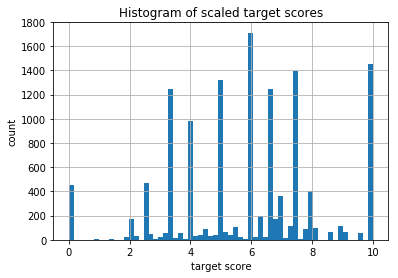

In [71]:
# score histogram
y.hist(bins=61)
plt.title('Histogram of scaled target scores')
plt.xlabel('target score')
plt.ylabel('count')
plt.savefig('image6.png', dpi=300)
plt.show()

In [72]:
from sklearn.model_selection import train_test_split

# Data to be split
X_train, X_test, y_train, y_test, scores_train, scores_test = \
        train_test_split(
                X, 
                y, 
                scores,
                test_size=0.2, 
                random_state=26
                )

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print('scores_train size: {}'.format(scores_train.shape))
print('scores_test size: {}'.format(scores_test.shape))

X_train size: (10380, 330)
X_test size: (2596, 330)
y_train size: (10380, 1)
y_test size: (2596, 1)
scores_train size: (10380, 4)
scores_test size: (2596, 4)


In [73]:
output_dim = y.shape[1]
input_dim = X.shape[1]
dropout = 0.2

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
        model.add(Dropout(dropout))

# Classification:
#         model.add(Dense(output_dim, activation='softmax'))

# Regression:
        model.add(Dense(output_dim))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(input_dim,1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(output_dim, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(input_dim,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(dropout)(x)
        x = Flatten()(x)
        outputs = Dense(output_dim, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

### Model Architecture

Of the three model architectures the multi-layer perceptron, or 'mlp', consistently produced the highest kappa scores in the shortest amount of calculation time. 

In [74]:
# Define keras model
model = None
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_train.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 14)                4634      
_________________________________________________________________
dropout_19 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 15        
Total params: 4,649
Trainable params: 4,649
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Compile the model
# Optimizer
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Classification:
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

# Regression:
model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])

In [76]:
# Define number of epochs
epochs = 100

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
#                       validation_split=0.3,
                      epochs=epochs, batch_size=15, verbose=0)

### Results

In [77]:
"""Classification: Test set predictions """
# y_proba = model.predict(X_test)
# y_pred = pd.Series(y_proba.argmax(axis=-1))

# Classification, if using pd.get_dummies:
# y_t = pd.Series(y_test.columns[np.where(y_test != 0)[1]])

# Classification, if using OneHotEncoder:
# y_t = csr_matrix.argmax(y_test, axis=1)
# y_t = pd.Series(np.squeeze(np.asarray(y_t)))

# Regression, use 'y_test'

'Classification: Test set predictions '

In [78]:
"""
Regression
True y, not needed for kappa metric because already passed with train, test, split
Used to verify reverse scaling
"""
y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))

In [79]:
"""Reverse scaling back to original target score scales"""

# Merge results
results = scores_test.reset_index(drop=True)\
                    .join(y_pred)\
                    .rename(columns={0:'y_pred'})\
                    .sort_values(by='topic')\
                    .reset_index(drop=True)
results.head()

,index,topic,target_score,scaled,y_pred
0,1751,1,10,8.0,7.987427
1,1075,1,12,10.0,9.096797
2,383,1,10,8.0,7.728758
3,706,1,10,8.0,6.776393
4,831,1,10,8.0,7.961109


Histograms of true and predicted target scores show generally a good agreement with the distribution trend. The plots are somewhat misleading since the scaled target scores have the same number of unique values before and after scaling. Since the Kappa metric calculates the distance, the spread of predicted values is not as worrisome.

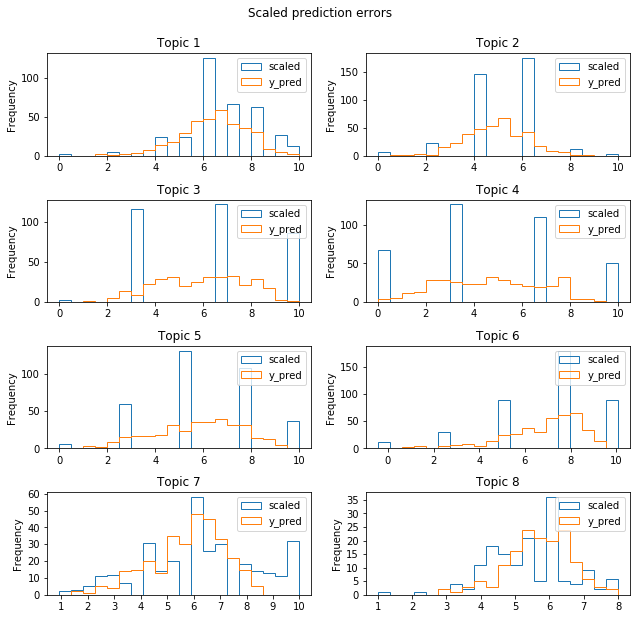

In [80]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            [['scaled', 'y_pred']]\
            .plot.hist(histtype='step', bins=20, ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Scaled prediction errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Prediction errors are greatest at the highest and lowest scores. Typically, the extreme scores have low representation and therefore the highest expected variance, therefore this is, once again, less worrisome.

In [83]:
results["diff"] = results["scaled"] -results["y_pred"] 

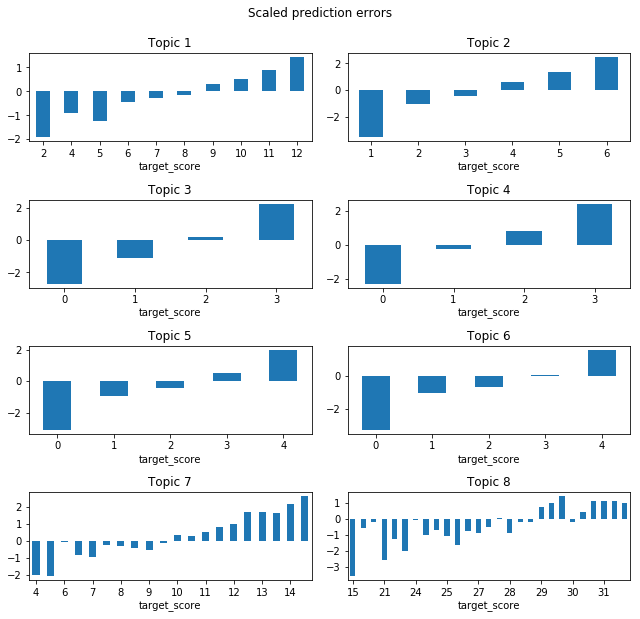

In [84]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            .groupby('target_score')['diff']\
            .median()\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Scaled prediction errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [85]:
""" Create list of tuples with min/max target scores sorted by topic number.
 Performed here on results in case min/max values didn't pass through train_test_split"""

score_df = results.groupby('topic')['target_score'].agg(['min', 'max'])  
score_ranges = list(zip(score_df['min'], score_df['max'])) 

"""Shrink back to original range by topic number:"""
y_p_df = pd.Series()
y_t_df = pd.Series()

for topic in range(1,9):
    scaler = MinMaxScaler(score_ranges[topic-1])
    scaled_pred = results[results.topic == topic]['y_pred'].to_frame()
    y_pred_shrunk = scaler.fit_transform(scaled_pred).round(0).astype('int')
    scaled_true = results[results.topic == topic]['scaled'].to_frame()
    y_true_shrunk = scaler.fit_transform(scaled_true).round(0).astype('int')
    y_p_df = y_p_df.append(pd.Series(np.squeeze(np.asarray(y_pred_shrunk))), ignore_index=True)
    y_t_df = y_t_df.append(pd.Series(np.squeeze(np.asarray(y_true_shrunk))), ignore_index=True)
    
# Append to results df
results['pred'] = y_p_df
results['y_true'] = y_t_df
results.head()

,index,topic,target_score,scaled,y_pred,diff,pred,y_true
0,1751,1,10,8.0,7.987427,0.012573,10,10
1,1075,1,12,10.0,9.096797,0.903203,11,12
2,383,1,10,8.0,7.728758,0.271242,10,10
3,706,1,10,8.0,6.776393,1.223607,8,10
4,831,1,10,8.0,7.961109,0.038891,10,10


The close agreement between true and predicted essay scores becomes apparent after re-scaling to their original ranges and plotting on a log scale by count.

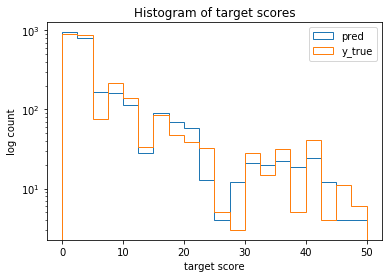

In [86]:
# score histogram

results[['pred', 'y_true']].plot.hist(histtype='step', bins=20, logy=True)
plt.title('Histogram of target scores')
plt.xlabel('target score')
plt.ylabel('log count')
plt.savefig('image8.png', dpi=300)
plt.show()

In [ ]:
# Classification accuracy:
# print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
#       (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

### A note on kappa scores

Some previous studies apply the kappa metric directly to the complete set of essays. Due to the differences in scale, essay topics (sets) that have a narrow scoring range will end up with significantly smaller weighted distances and thus artificially high kappa scores. Kappa scores of up to 94.5% have been reported with this metric.

Other studies calculate the kappa score for each topic individually and then report the geometric mean.

The method most likely used in the original Kaggle competition (there is some doubt whether the published code matches the one actually used), uses the quadratic weighted kappa for each set individually and then calculates the mean of the quadratic weighted kappas after applying Fisher's r-to-z transform, which is approximately a variance-stabilizing transformation. Each set is weighted by a factor of one, except for topic 2 which has two domain raters which are each weighted 0.5. It is not clear why the scores are not weighted by the number of essays in each set, then again, the actual formulas used in the competition have not been published.

The kappa scores from the original competition were based on comparison to unpublished test data scores. Since all published work on this data set only used the training data set, kappas cannot be compared directly to competition results.

Finally, most published work used a subset of essay sets (topics). Omitting topics is likely going to change kappa scores for better or worse.

In [88]:
k = kappa(results.pred, results.target_score, weights='quadratic')
print('Combined essay kappa score: {:.4f}'.format(k))

Combined essay kappa score: 0.9774


The combined essay topics kappa score is much higher than that obtained from individual topics, however, as noted above, this is deceptive, as shown in a recalculation below:

In [89]:
qwk = []
# weights = []
for topic in range(1,9):
    qwk.append(
            kappa(results[results.topic == topic]['target_score'], 
                  results[results.topic == topic]['pred'],
                    weights='quadratic'))
#     weights.append(len(results[results.topic==topic])/X_test.shape[0])    
mqwk = mean_quadratic_weighted_kappa(qwk, weights=1)
print('Weighted by topic Kappa score: {:.2f}%'.format(mqwk * 100))

Weighted by topic Kappa score: 68.60%


In [90]:
qwk

[0.75703519834237,
 0.5934349461815619,
 0.5987424259746199,
 0.6908347889134232,
 0.7766407141902107,
 0.6849517379608628,
 0.7569496762989542,
 0.5686349035609094]

In [91]:
# kappa for two human raters
qwk = []
# weights = []
for topic in range(1,9):
    qwk.append(
            kappa(training_set[training_set.topic == topic]['rater1_domain1'], 
                  training_set[training_set.topic == topic]['rater2_domain1'],
                    weights='quadratic'))
#     weights.append(len(results[results.topic==topic])/X_test.shape[0])    
mqwk = mean_quadratic_weighted_kappa(qwk, weights=1)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Weighted by topic Kappa score: 0.7612


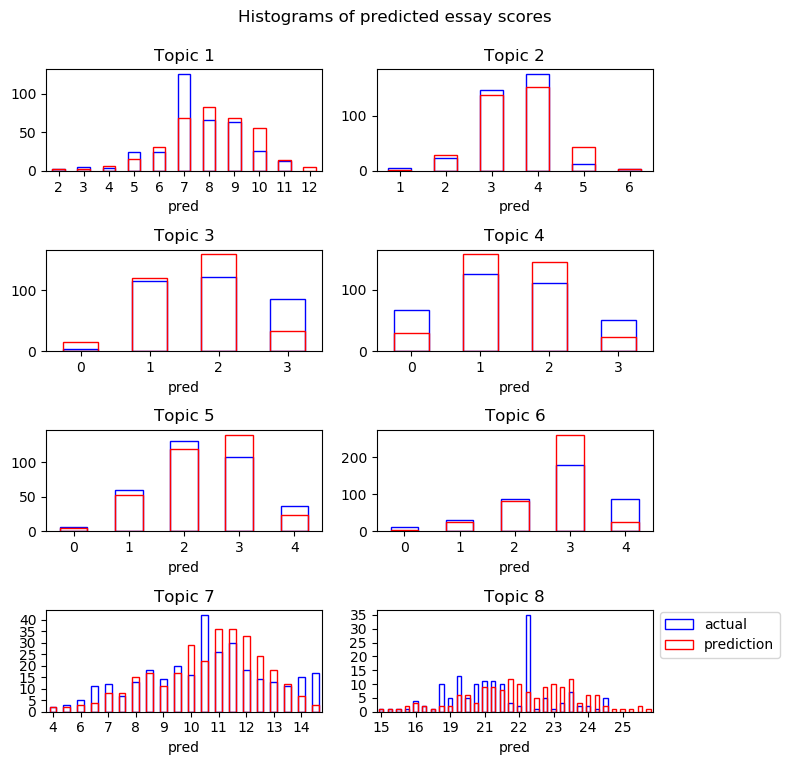

In [92]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,8), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            .groupby('y_true')['y_true']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='b', label='actual')
        results[results['topic'] == topic_number]\
            .groupby('pred')['pred']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='r', label='prediction')
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of predicted essay scores')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [94]:
estimator.history

{'loss': [19.681520030677664,
  6.270065423208854,
  5.276282177839665,
  4.82821433185842,
  4.509615909329729,
  4.360702702937099,
  4.209479386234559,
  4.145006628567084,
  4.045130285827411,
  3.9522295649341075,
  3.9047647697388093,
  3.8728116146918667,
  3.9084415318648937,
  3.8070666812403355,
  3.7776333053160265,
  3.783198994708199,
  3.7413616202814732,
  3.6408025307979197,
  3.694519876572438,
  3.6869418104259952,
  3.59652306535685,
  3.618754366401992,
  3.625277663414189,
  3.575315870129304,
  3.4927366497371928,
  3.4894483128207265,
  3.5643312081780736,
  3.433034182800723,
  3.4768799912033743,
  3.403204771135584,
  3.4405390126684496,
  3.3818327301327202,
  3.3729688449402078,
  3.3835036957022773,
  3.370870030770412,
  3.3311928179050456,
  3.3638353508848677,
  3.2929148205442926,
  3.309800950864147,
  3.3030774519278134,
  3.2681516798245425,
  3.302187870434254,
  3.212721572704398,
  3.255420160086858,
  3.213740612299456,
  3.2402415264376327,
  3.

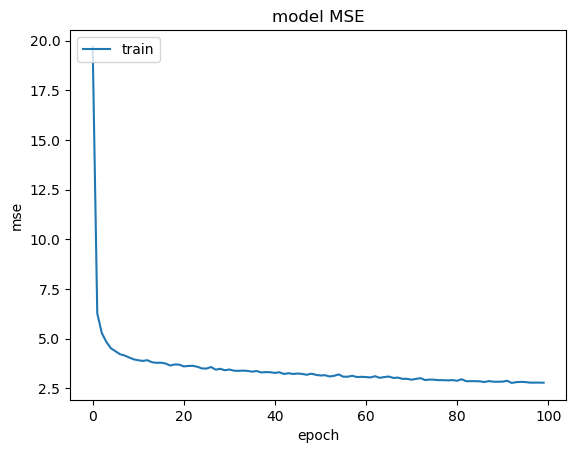

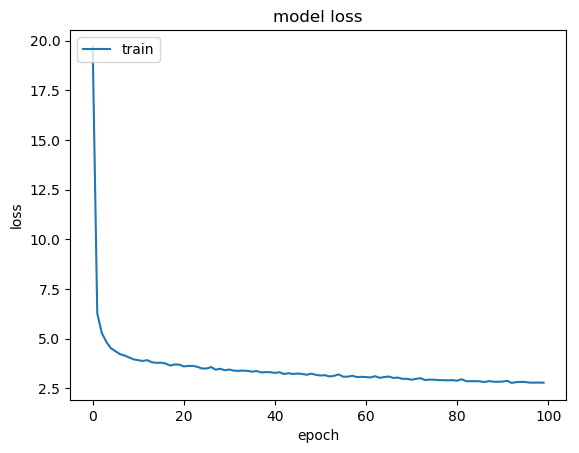

In [97]:
"""
Use this for plotting regression mean-squared error
Validation split must be enabled during model fit.
"""
# Plot model mse over epochs
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['mean_squared_error'])
#plt.plot(estimator.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.ylim(0,300)
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
#plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

The most significant improvement occurs in the first 10 or 20 epochs, however the model continues to improve slightly with additional epochs.

In [ ]:
"""Use this for plotting classification accuracy"""
# # Plot model accuracy over epochs
# sns.reset_orig()   # Reset seaborn settings to get rid of black background
# plt.plot(estimator.history['acc'])
# plt.plot(estimator.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')
# plt.show()

# # Plot model loss over epochs
# plt.plot(estimator.history['loss'])
# plt.plot(estimator.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')
# plt.show()

In [99]:
# Check for scaling errors
errors = len(results.query('y_true != target_score')[['topic', 'target_score', 'y_true']])

print('{:.1f}% of target scores did not revert back to their original value.'.format(errors/results.shape[0] * 100))

0.0% of target scores did not revert back to their original value.


## Summary

Of all the model architectures attempted, a multi-layer perceptron with surprisingly few nodes in the hidden layer returned the highest Kappa score. Additional hidden layers did not improve the model.

Automatic scoring can be framed as both a classification or a regression problem. The highest target metrics (mean quadratic weighted kappa) were found using regression analysis.

Comparisons to the original Kaggle competition and later attempts are often unfair due to differences in data sets and methods of calculating kappa. The results obtained in this notebook are among the highest, if not the highest currently published.

## Outlook

Additional optimization is definitely possibly by tweaking hyperparameters and calculating more epochs. Additional features could be extracted and added to the feature set. While this would almost certainly result in higher kappa scores, the additional gain wouldn't outweigh the benefit. Perhaps the biggest obstacle is the limited data. If some day scores for the validation and test data sets are released, it would be worthwhile revisiting the problem set.